# Hyperparameter tuning for Gaussian Process regression via Maximum Likelihood estimation 
Make the most of your machine learning (ML) model by getting the hyperparameters right. 

After motivating the importance of hyperparameters for achieving strong model performance, we provide some perspective on how hyperparameters are treated in Bayesian statistics and derive the evidence approximation. Based on this approximation, we demonstrate hyperparameter tuning for a regression task that is modeled with a Gaussian Process (GP). We give an overview of GP regression and present the mathematical framework for learning and making predictions. Next, we harness these theoretical insights to perform a maximum likelihood estimation by minimizing the negative logarithm of the marginal likelihood w.r.t. the hyperparameters using the numerical Broyden–Fletcher–Goldfarb–Shanno (BFGS) algorithm. After giving some pointers on how this algorithm works, we demonstrate the effect of local minima on prediction accuracy and model interpretation.


<div class="alert alert-block alert-info"><b>Tip: Get the source code</b>

In the code blocks, we will use `gp_regression`—a simple, object-oriented, and unit-tested python package for performing Gaussian Process Regression—that I wrote for demonstration purposes. 
We will use this package to build different models, tune their hyperparameters and visualize predictions.

You can find `gp_regression` and detailed installation instructions in this [<b>GitHub repository</b>](https://github.com/chris-hoffmann/blog_posts/tree/master/1_hyperparameter_tuning_for_gaussian_process_regression). </div> 

## Table of Contents

1. [Strategies for identifying good hyperparameters](#strategies_hyper_opt)
2. [Bayesian treatment of hyperparameters](#bayesian_hyper_opt)
3. [Gaussian Processes](#gaussian_processes)
4. [Maximum likelihood estimation based on the BFGS algorithm](#hyper_tuning)
5. [Effect of Local Minima on Model interpretation](#local_minima)
6. [Conclusion and Outlook](#conclusion)

## 1. Strategies for identifying good hyperparameters  <a id="strategies_hyper_opt"></a>
---

In most areas of Machine learning, we seek to determine parameters that yield accurate predictions. If you think of neural networks, these parameters would be your weights and biases, and they are learned via backpropagation aiming to minimize a pre-defined cost function.

Hyperparameters, on the other hand, are not learned during training but selected beforehand. They are often required to specify your model fully. Let us take a look at some examples: The number of hidden units in a neural network, the value of the learning rate of the optimizer, the number of clusters for k-means clustering, the regularization strength in regression, all these examples represent hyperparameters. Finding a good set of hyperparameters for a given model and data set can make the difference between mediocre and excellent performance in terms of delivering accurate predictions. So, investing time in identifying good hyperparameters is certainly time well spent. The most common approach is to screen different values by applying a grid search: For each hyperparameter, we define a discrete interval of logarithmically spaced values that are used for training and evaluated on a validation set. The combination of hyperparameters that performs best is then employed for predictions on the test set. An alternative to grid search is to evaluate the performance of randomly chosen hyperparameter combinations. There is a classic paper that compares grid and random search strategies with the empirical result that random search often yields better hyperparameters while also requiring less computation time  [[1]](#ref-1). 

In this blog post, we focus on the third approach for identifying good hyperparameters, which relies on Bayesian statistics. We outline some Bayesian principles for treating hyperparameters in the following section and then continue by examining a concrete example for hyperparameter tuning based on the empirical Bayes method.

## 2. Bayesian treatment of hyperparameters <a id="bayesian_hyper_opt"></a>
---
Bayesian inference provides a hierarchical three-level framework to infer the optimal parameters (level I) and hyperparameters (level II), and to compare different models [[2]](#ref-2). 

A fully Bayesian approach for predicting the unknown output $y_*$ of a test point $x_*$ for a given model $M$ and data set $D$ involves integrating the (full) posterior over parameters $\mathbf{w}$ and hyperparameters $\boldsymbol\alpha$:

$
\begin{align}
p(y_*|x_*,D,M) = \int \int p(y_*|x_*,D,\mathbf{w},\boldsymbol{\alpha})\,p(\mathbf{w}|D,\boldsymbol\alpha)\,p(\boldsymbol{\alpha}|D) \operatorname {d} \!\mathbf{w} \operatorname {d} \!\boldsymbol\alpha \text{,}
\end{align}
$

where $p(y_*|x_*,D,\mathbf{w})$ is the likelihood, $p(\mathbf{w}|D,\boldsymbol\alpha)$ is the posterior over parameters and $p(\mathbf{\boldsymbol\alpha}|D)$ is the posterior over hyperparameters.

But this integral is intractable even in the case that all composing distributions are Gaussian. One remedy could be to approximate it using Markov chain Monte Carlo sampling or variational methods, and there is a recent paper that explores and contrasts both approaches [[3]](#ref-3). 

In practice, the most common Bayesian-like approach is based on the evidence approximation: Instead of specifying a prior distribution over hyperparameters (hyperprior), we assume that the posterior over hyperparameters is sharply peaked around $\hat{\boldsymbol\alpha}$ and therefore 

$
\begin{align}
p(y_*|x_*,D,M) \approx \int p(y_*|x_*,D,\mathbf{w},\hat{\boldsymbol{\alpha}})\,p(\mathbf{w}|D,\hat{\mathbf{\boldsymbol\alpha}}) \operatorname {d} \!\mathbf{w}.
\end{align}
$

To determine this hyperparameter vector $\hat{\boldsymbol{\alpha}}$ where the posterior $p(\mathbf{\boldsymbol\alpha}|D) \approx p(\mathbf{y}|\mathbf{X},\boldsymbol\alpha)\,p(\boldsymbol\alpha)$ is maximal, let us further assume that the hyperprior $p(\boldsymbol\alpha)$ is very flat. Then we are left with the marginal likelihood distribution $p(\mathbf{y}|\mathbf{X},\boldsymbol\alpha)$, which gives the likelihood of the outputs $\mathbf{y}$ given the set of inputs $\mathbf{X}$ and hyperparameters. 
Since the inputs are fixed, we can use this function to tune our set of hyperparameters by maximizing the likelihood:

$
\begin{align}
\hat{\boldsymbol\alpha }=\underset {\boldsymbol\alpha}{\operatorname {arg\;max}}\ {p(\mathbf{y}|\mathbf{X},\boldsymbol\alpha)}. 
\end{align}
$

The term marginal refers to the fact that the (latent) parameters have been integrated out. Note that the marginal likelihood is the normalizing constant of the posterior distribution over parameters at level 1, which is also termed (model) evidence, but also corresponds to the likelihood at level 2.

## 3. Gaussian processes <a id="gaussian_processes"></a>
---

Gaussian processes (GPs) are a powerful statistical tool for performing various ML tasks such as classification and regression. 
Here, we will use them to learn a model for a regression task, which is a bit more straightforward. If you are interested in the latter, there is a classic textbook on GPs that devotes an entire chapter to classification modeling with GPs [[4]](#ref-4).

In simple words, a GP can be used to model a distribution over functions. Let us explore what this means by starting with the definition of a stochastic process: A stochastic process is a collection of infinite random variables that are ordered by an index that often represents time. Such a process is said to be Gaussian if and only if any subset of those random variables gives a joint normal distribution.
Soon, we will see how these definitions help solve a regression problem, which can be formulated as 
$y(\mathbf{x}) = f(\mathbf{x}) + \epsilon$, where the residuals $\epsilon$ are modeled as white noise meaning they are normally, independently and identically distributed with zero mean: $\epsilon$  $\sim \mathcal{N}(0,\sigma^2_{n})$.

Intuitively such a stochastic process can be represented by a random continuous function $\mathbf{f}$ that, if defined on an unbounded interval, accepts a (possibly) infinite-dimensional input vector that is mapped to a set of random variables.
Next, let us assume such a function is drawn from a multivariate GP of dimension $N$, where $N$ is the number of observed data points given a labeled data set $D=\left (\mathbf{X}, \mathbf{y}  \right )=\{\mathbf{x}_i, y_i\}_{i=1}^N$ with inputs $\mathbf{x} \in \mathbb{R}^d$ and (numeric) outputs $\mathbf{y} \in \mathbb{R}$.  

In analogy to the normal distribution that is characterized by the mean and covariance, a GP—which can be seen as a generalization of a multivariate Gaussian normal distribution to infinite dimension—is fully specified by a mean function $m(\mathbf{x})$ and covariance function $k(\mathbf{x}, \mathbf{x}')$:
$f(\mathbf{x}) \sim \mathcal{GP}(m(\mathbf{x}),\, k(\mathbf{x}, \mathbf{x}'))$.
Building on the previous definitions, the subset of function values $\mathbf{f}=f(\mathbf{X})$ has a joint Gaussian distribution $\mathbf{f} \sim \mathcal{N}(0, \mathbf{K})$.
In matrix notation, this reads as 

$\begin{align*}
\begin{bmatrix}
f(\mathbf{x}_1) \\
f(\mathbf{x}_2) \\
\vdots \\
f(\mathbf{x}_N)
\end{bmatrix} &\sim  \mathcal{N}
\begin{pmatrix}
\begin{bmatrix}
0\\
0\\
0\\
0
\end{bmatrix},&
\begin{bmatrix}
k(\mathbf{x}_1, \mathbf{x}_1) & k(\mathbf{x}_1, \mathbf{x}_2) & \cdots & k(\mathbf{x}_1, \mathbf{x}_N)\\
k(\mathbf{x}_2, \mathbf{x}_1) & k(\mathbf{x}_2, \mathbf{x}_2) & \cdots & k(\mathbf{x}_2, \mathbf{x}_N)\\
\vdots & \vdots & \ddots & \vdots \\
k(\mathbf{x}_N, \mathbf{x}_1) & k(\mathbf{x}_N, \mathbf{x}_2) & \cdots & k(\mathbf{x}_N, \mathbf{x}_N)
\end{bmatrix}
\end{pmatrix}
\end{align*},$

where $\mathbf{K}$ is the covariance matrix whose entries are $K_{ij}=k(\mathbf{x}_i,\mathbf{x}_j)$.
Statistically speaking, we have placed a Gaussian process prior on $\mathbf{f}$ given the inputs and hyperparameters that specify our covariance functions. 

One extremely useful consequence of this prior is that all other distributions that we are possibly interested in such as the joint, marginal and conditional distribution are Gaussians as well, which in turn allows for computing the posterior distribution in closed form. This is a rare treat in Bayesian statistics, where we often have to rely on approximations.

Next, let us parameterize the covariance function $k:\mathbb{R}^d \times \mathbb{R}^d \to \mathbb{R}$ that measures the degree of similarity between pairs of training points and thus is often considered to be a function of the distance between $x$ and $x'$.

We are pretty flexible in specifying the mathematical form of the covariance function, as long as the covariance matrix $\mathbf{K}$, whose entries are $K_{ij}=k(\mathbf{x}_i,\mathbf{x}_j)$, is positive semidefinite, which means that all its eigenvalues are positive or more formally $\mathbf{v}^T \mathbf{K}\mathbf{v} > 0$, for all vectors $\mathbf{v} \in \mathbb{R}^n$. Selecting the form of the covariance function also permits us to encode assumptions about our data and how they might have been generated.

The squared exponential (SE) covariance function

$
\begin{align*}
k_{SE}(\mathbf{x}, \mathbf{x}') = \exp\left( \dfrac{- \lVert \mathbf{x}-\mathbf{x}' \rVert^2_2}{2l^2}\right),
\end{align*}
$ 

where $\lVert \mathbf{x}-\mathbf{x}' \rVert_2 = \sqrt{\sum_{i=1}^d (x_i-x'_i)^2}$ denotes the Euclidean distance, which is probably the most frequent choice. This function is infinitely differentiable and thus very smooth. The Euclidean distance metric makes $k_{SE}$ stationary meaning that its value only depends on the relative distance between input pairs. Models that employ $k_{SE}$ as covariance function allow for easy interpretation of both hyperparameters, noise $\sigma_n^2$ and standard deviation  $l$. While the former encodes beliefs about the measurement noise, the latter can be seen as a length-scale that tunes the degree of correlation between two training points at a given pair distance. Below we illustrate the role of the length-scale by comparing two different values. But first, let us specify our model.

### Build a model for Gaussian Process Regression

It is about time to build our first model for GP Regression using `gp_regression`, which only depends on NumPy, Matplotlib and the optimize module from SciPy.

In [1]:
from gp_regression import GP
from gp_regression.kernels import kernel_factory

import numpy as np
from scipy.optimize import LinearConstraint

In [2]:
# Define the training set and the test inputs:

X = np.array([-5,-3,0,0.1,1,4.9,5]) # training inputs
y = np.array([0,-0.5,1,0.7,0,1,0.7]) # training outputs
X_star = np.linspace(-6, 6, 101) # test inputs

In [3]:
# Specify a Gaussian covariance kernel:

gauss_kernel_small_length_scale = kernel_factory('gaussian', length_scale=0.1)

In [4]:
# Build a first GP model using $k_{SE}$: 

gpr_model_small_length_scale = GP(X, y, X_star, metric='seuclidean', kernel=gauss_kernel_small_length_scale, noise=0.2)

In [5]:
# Print a summary of the model:

gpr_model_small_length_scale

model: {'kernel': Gaussian, 'metric': 'seuclidean'}
hyperparameter: {'noise': 0.2, 'length_scale': 0.1}
X: array([-5. , -3. ,  0. ,  0.1,  1. ,  4.9,  5. ])
y: array([ 0. , -0.5,  1. ,  0.7,  0. ,  1. ,  0.7])
X_star: array([-6.  , -5.88, -5.76, -5.64, -5.52, -5.4 , -5.28, -5.16, -5.04,
       -4.92, -4.8 , -4.68, -4.56, -4.44, -4.32, -4.2 , -4.08, -3.96,
       -3.84, -3.72, -3.6 , -3.48, -3.36, -3.24, -3.12, -3.  , -2.88,
       -2.76, -2.64, -2.52, -2.4 , -2.28, -2.16, -2.04, -1.92, -1.8 ,
       -1.68, -1.56, -1.44, -1.32, -1.2 , -1.08, -0.96, -0.84, -0.72,
       -0.6 , -0.48, -0.36, -0.24, -0.12,  0.  ,  0.12,  0.24,  0.36,
        0.48,  0.6 ,  0.72,  0.84,  0.96,  1.08,  1.2 ,  1.32,  1.44,
        1.56,  1.68,  1.8 ,  1.92,  2.04,  2.16,  2.28,  2.4 ,  2.52,
        2.64,  2.76,  2.88,  3.  ,  3.12,  3.24,  3.36,  3.48,  3.6 ,
        3.72,  3.84,  3.96,  4.08,  4.2 ,  4.32,  4.44,  4.56,  4.68,
        4.8 ,  4.92,  5.04,  5.16,  5.28,  5.4 ,  5.52,  5.64,  5.76,
        5.88

### Examine the effect of the length-scale

Now, we build a second model for which $k_{SE}$ has a larger length-scale ($l=3.0$) than in 
the first model ($l=0.1$). Otherwise, all settings and data are identical. We compare both models to probe the effect of the length-scale by drawing three samples from the prior distribution of each model.

In [6]:
# Build a second GPR model using a squared exponential covariance function with a larger length-scale:

gauss_kernel_large_length_scale = kernel_factory('gaussian', length_scale=3.0)
gpr_model_large_length_scale = GP(X, y, X_star, metric='seuclidean', kernel=gauss_kernel_large_length_scale, noise=0.2)

In [7]:
# Configure some plot settings:

import matplotlib.pyplot as plt

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.serif'] = "Helvetica"
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['font.size'] = 13

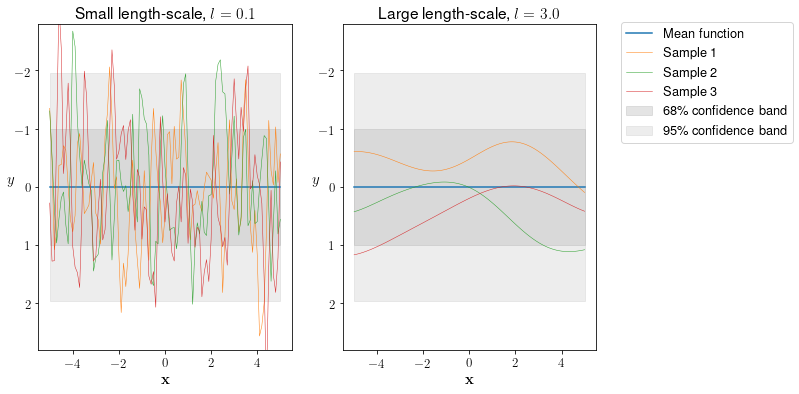

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(10,6))

length_scales = []
size_labels = ['Small', 'Large']


for (ax_id, model) in zip(range(2), [gpr_model_small_length_scale, gpr_model_large_length_scale]):
    model.draw_from_prior(plot=True, ax=axes[ax_id])
    length_scales.append(model.kernel.kernel_params['length_scale'])  
    axes[ax_id].set_xlabel(r'$\mathbf{x}$')
    axes[ax_id].set_ylabel(r'$y$', rotation=0)
    axes[ax_id].set_ylim(2.8,-2.8)
    
for idx,(length_scale,size_label) in enumerate(zip(length_scales,size_labels)):
    axes[idx].set_title(f'{size_label} length-scale, $l={{{length_scale}}}$')

    
axes[0].get_legend().remove()
axes[1].legend(loc='center right', bbox_to_anchor=(1.3, 0.57, 0.5, 0.5))
plt.savefig('test.png', dpi=100, bbox_inches='tight')

<img align='left' src="img_notebook/blog_post_15_1.png"> <a name="fig-1"></a>

**Figure 1**: Comparison of two different length-scales for $k_{SE}$. For each length-scale, three functions drawn from the prior distribution, using 100 equally spaced points in $[-4,4]$ as input, are shown. 

The smaller length-scale $l = 0.1$ (left panel in [Figure 1](#fig-1)) results in rapidly fluctuating functions, which gives more flexibility to fit our training data. Most entries of the resulting covariance matrix would be close to zero since $\lim_{l \to 0 } k_{SE}(\lVert \mathbf{x}-\mathbf{x}' \rVert) = 0$. On the other hand, a larger length-scale $l = 3.0$ (panel in [Figure 1](#fig-1)) produces very smooth covariance functions and the underlying covariance matrix would contain many entries that are close to one since $\lim_{l \to \infty } k_{SE}(\lVert \mathbf{x}-\mathbf{x}' \rVert) = 1$ implying that even larger pair distances bear some relevance.

### The marginal likelihood

As with latent parameters, we can integrate the latent functions $\mathbf{f}$ out of the product of the likelihood and the prior which gives rise to the marginal likelihood 

$
\begin{equation*}
p(\mathbf{y}) = \int p\left (\mathbf{y} | \mathbf{f} \right ) p(\mathbf{f}) \,d\mathbf{f} = \mathcal{N}(\mathbf{y}; 0, \underbrace{\mathbf{K}+\sigma_n^2 I}_\mathbf{K_n}) = \dfrac{1}{2\pi^{N/2}} \cdot \dfrac{1}{\sqrt{\rvert\mathbf{K_n}\lvert}}\exp\left(-\dfrac{1}{2}\mathbf{y}^T\mathbf{K_n}\,\mathbf{y}\right).
%\label{eq:vector_ray} \tag{1}
\end{equation*}
$

The marginal likelihood $p(\mathbf{y})$ indicates the probability of the data given our model and thus measures how well our model fits the data, which is determined by the choice of the covariance function and distance metric, as well as the associated hyperparameters. Therefore, we can employ the marginal likelihood to train a GP model, which boils down to selecting a suitable covariance function and finding optimal hyperparameters.

From a computational point of view, it is more convenient to work with the logarithm of the marginal likelihood, which reads as 

$
\begin{equation*}
\log p \left(\mathbf{y} | \mathbf{X},\alpha \right) = - \frac{1}{2} \left( N\log{2\pi} + \log{\rvert\mathbf{K_n}\lvert} + \mathbf{y}^T\mathbf{K_n}^{-1}\mathbf{y} \right ).
\end{equation*}
$

The first term $N\log{2\pi}$ is a normalizing constant, the second term $\log{\rvert\mathbf{K_n}\lvert}$ is a complexity penalty that serves as a valve against overfitting, while the third term $\mathbf{y}^T\mathbf{K_n}^{-1}\mathbf{y}$, that depends on the training outputs, represents a fit to the data.

The expression for the marginal likelihood also shows that a good fit could be offset by the complexity penalty: We see that as the length-scale decreases, the inverse of the covariance matrix $\mathbf{K_n}^{-1}$ increases but at the same time its determinant $\rvert\mathbf{K_n}\lvert$ shrinks. 

The former sections have equipped us with useful background knowledge for identifying good hyperparameters $\boldsymbol\alpha = [\sigma_n^2, l]^T$ for $k_{SE}$.
To this end, we perform a maximum likelihood estimation, which means we maximize the marginal likelihood as a function of $\boldsymbol\alpha$. Computationally, it is more convenient to reframe this estimation as a minimization of the negative logarithm of the likelihood function,

$
\begin{equation}
\hat{\boldsymbol \alpha }=\underset {\boldsymbol \alpha}{\operatorname {arg\;min}}\ {\mathcal{L}},
\end{equation}
$ 

where $\mathcal{L} = -\log p \left(\mathbf{y} | \mathbf{X},\boldsymbol \alpha \right)$.

## 4. Maximum likelihood estimation based on the BFGS algorithm <a id="hyper_tuning"></a>
---

### Newton's method
 
Now, we are ready to minimize our objective function $\mathcal{L}$ using a numerical
optimization algorithm (optimizer), mostly variants of Newton's method. 
In short, this means we perform a series of iterations until the norm of the gradient $||\nabla \mathcal{L}(\boldsymbol\alpha)||$ falls under a given threshold, which is very close to zero and thus indicates that we have reached a stationary point. Formally, the iterative scheme can be summarized as follows:

$
\begin{equation}
\mathbf{\boldsymbol\alpha}^{k+1} = \mathbf{\boldsymbol\alpha}^k - \dfrac{\nabla \mathcal{L}(\boldsymbol\alpha^k)}{\mathbf{H}(\boldsymbol\alpha^k)}, 
\end{equation}
$

where $\boldsymbol\alpha^{k+1}$ and $\boldsymbol\alpha^k$ are the current iterate and next iterate, respectively, and $\mathbf{H}$ is the Hessian Matrix, whose entries are second-order partial derivatives $H_{i,j}={\dfrac {\partial ^{2}\mathcal{L}}{\partial \boldsymbol\alpha_{i}\partial \boldsymbol\alpha_{j}}}$. The ratio between gradient and Hessian determines the search direction and magnitude of the increment $\mathbf{h}$.
The scheme relies on a second-order Taylor expansion around $\boldsymbol\alpha^k$ assuming that $\mathcal{L}$ is twice-differentiable

$ \mathcal{L}(\boldsymbol\alpha^k+\mathbf{h})\approx \mathcal{L}(\boldsymbol\alpha^k) + \mathbf{h}^T \mathbf{g}^k + \frac{1}{2} \mathbf{h}^T \mathbf{H}^k \mathbf{h}.$

As the gradient vanishes at the minimum, we seek the increment $\mathbf{h}$ that minimizes our quadratic approximation

$ \nabla_\mathbf{h} \left (\mathcal{L}(\mathbf{\boldsymbol\alpha}^k+\mathbf{h} \right) \overset{!}{=} 0 = \mathbf{g}^k + \mathbf{H}^k \mathbf{h},$

which yields our iterative scheme for $\mathbf{h}=\Delta \mathbf{\boldsymbol \alpha} = \mathbf{\boldsymbol \alpha}^{k+1} - \mathbf{\boldsymbol \alpha}^{k}.$


###  SciPy for performing the minimization in practice
Practically, we use the SciPy function `minimize` from the optimize module to perform the minimization, which requires an objective function and start values for $\boldsymbol\alpha$ as input. By default, the iteration stops if the gradient norm becomes less than $10^{-5}$. We can also opt for specifying the gradient explicitly, which otherwise is estimated numerically. When we miss specifying the optimizer, then `minimize` will automatically pick the BFGS (Broyden-Fletcher–Goldfarb-Shanno) algorithm for unconstrained and unbound minimization problems, which provides a good trade-off between speed and accuracy. 

### A high-level description of the BFGS algorithm
If you want to dive deeper into how BFGS works, which is named after its discoverers, this is a pretty useful resource [[5]](#ref-5). Here, we will just give a few pointers to develop an understanding as to how the algorithm works in principle. BFGS is one of several quasi-Newton methods that, for the sake of computational efficiency, approximate the inverse Hessian based on the information from two successive gradients. Formally, the approximation is chosen to satisfy the secant equation:

$
\begin{equation}
\dfrac{\nabla \mathcal{L}(\boldsymbol\alpha^{k+1})- \nabla \mathcal{L}(\boldsymbol\alpha^{k})}{\boldsymbol\alpha^{k+1} - \boldsymbol\alpha^k} = \mathbf{B}(\boldsymbol\alpha^{k+1}) \approx \mathbf{H}(\boldsymbol\alpha^{k+1}).
\end{equation}
$

In higher dimensions, the secant equation is under-determined and the various quasi methods differ in the additional conditions that they impose to solve the secant equation. The BFGS variant imposes the so-called curvature condition 

$
\begin{equation}
\left (\boldsymbol\alpha^{k+1} - \boldsymbol\alpha^k \right)^T \left ( \nabla \mathcal{L}(\boldsymbol\alpha^{k+1}) - \nabla \mathcal{L}(\boldsymbol\alpha^{k})\right) > 0, 
\end{equation}
$

which can be obtained by multiplying the secant equation on the left by $\left (\boldsymbol\alpha^{k+1} - \boldsymbol\alpha^k \right)^T$.
If the curvature condition holds, the secant equation has a solution that ensures the positive definiteness of the approximated Hessian, which is one virtue of the BFGS update. In practice, a new estimate $B^{k+1}$ is obtained by adding two (symmetric rank-one) correction matrices to the previous estimate $B^k$: 

$
\begin{equation}
B^{k+1}=B^{k}+U^{k}+V^{k}.
\end{equation}
$

Additional constraints make sure that the new update is a symmetric matrix and close to the previous iterate $B^{k}$, which allows determining $B^{k+1}$ uniquely. 

### Set hyperparameters via a Maximum likelihood estimation

Now, it is time to tune the hyperparameters of our GP regression model, i.e., the length-scale $l$ of $k_{SE}$ and the noise level $\sigma_n^2$ via a maximum likelihood estimation. Subsequently, we print a report that summarizes our attempt.

In [9]:
# Tune hyperparameters:

gpr_model_large_length_scale.tune_hyperparameters()

Optimization terminated successfully.
         Current function value: 6.677446
         Iterations: 10
         Function evaluations: 60
         Gradient evaluations: 15


(array([ 0.22233858, 10.66407922]), 6.677445853887794)

In [10]:
# Let us print a report that summarizes the (last) minimization:

gpr_model_large_length_scale.mininmization_report

model: {'kernel': Gaussian, 'metric': 'seuclidean'}
start_values: {'noise': 0.2, 'length_scale': 3.0}
optimizer: BFGS
success: True
optimal_values: {'noise': 0.222, 'length_scale': 10.664}


## 5. Effect of Local Minima on Model interpretation <a id="local_minima"></a>
---
After having identified good hyperparameters, let us use them to predict the unknown function $\mathbf{f}_{*}$ for the test inputs $\mathbf{X}_{*}$. To this end, we compute the predictive posterior distribution $p(\mathbf{f}_* | \mathcal{D}, \mathbf{X}_*)$, which is conditioned on the observed training data. As you have probably guessed by now, this distribution turns out to be Gaussian as well:

$
\begin{equation*}
p(\mathbf{f}_* | D, \mathbf{X}_*) \sim \mathcal{N}\left(\boldsymbol\mu_*, \boldsymbol\Sigma_*\right),
\end{equation*}
$

where $\boldsymbol\mu_* = \mathbf{y}_* = \mathbb{E}(\mathbf{f}_*) = \mathbf{K}(\mathbf{X}_*,\mathbf{X}) \mathbf{K_n}^{-1} \mathbf{y}$ 

and $\Sigma_* = \mathbf{K}(\mathbf{X}_*, \mathbf{X}_*) - \mathbf{K}(\mathbf{X}_*,\mathbf{X})\mathbf{K_n}^{-1}\mathbf{K}(\mathbf{X}_*, \mathbf{X})^T$.

At first glance, the expressions for the predictive mean $\boldsymbol\mu_*$ and the predictive covariance matrix $\boldsymbol\Sigma_*$ may look a bit involved, but in principle all we are asked to do is (1) to invert the covariance matrix for training inputs $\mathbf{K_n}$, and (2) to compute the covariance matrices for all pairs between test inputs $\left(\mathbf{K}(\mathbf{X}_*, \mathbf{X}_*) \right)$ and between test and training inputs $\left(\mathbf{K}(\mathbf{X}_*,\mathbf{X})\right)$. The matrix inversion requires $\mathcal{O}(N^3)$ operations and presents the computational bottleneck for learning with Gaussian processes. Hence, for large training sets approximations are needed that result in a sparse covariance matrix. 

For $m$ test points \($\mathbf{X}_*=\{\mathbf{x_*}\}_{i=1}^m$\) our prediction yields a $m$-dimensional Gaussian distribution, which in turn enables us to estimate the uncertainty for the predicted outputs $\mathbf{y}_*$ from the predictive variance: 

$
\begin{equation*}
\DeclareMathOperator{\diag}{diag}
\boldsymbol\sigma(\mathbf{y}_*)=\sqrt{\diag({\boldsymbol\Sigma_* + \sigma_n^2I})}.
\end{equation*}
$

Since the BFGS algorithm presents a local optimizer, the convergence of a minimization depends on the chosen start values. As a result, we might end up in a different local minimum of the marginal likelihood representing other hyperparameters if we initialize the objective function with distinct values. Below, we further investigate the resulting consequences of this by comparing two models that only differ in the tuned hyperparameters.

### Perform another Maximum likelihood estimation with different start values 

We select new hyperparameters for the next minimization round and then perform a (constraint) optimization using these as start values.

In [11]:
# Select new hyperparameters:

gpr_model_small_length_scale.noise = 0.002
gpr_model_small_length_scale.kernel.kernel_params['length_scale'] = 1.0

In [12]:
# Perform a constraint optimization using the new hyperparameters as start values:

gpr_model_small_length_scale.tune_hyperparameters(constraints=[LinearConstraint(np.eye(2), [0,0], [0.05,1])])

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 5.730297522228307
            Iterations: 7
            Function evaluations: 30
            Gradient evaluations: 7


(array([0.03197729, 1.        ]), 5.730297522228307)

In [13]:
gpr_model_small_length_scale.mininmization_report

model: {'kernel': Gaussian, 'metric': 'seuclidean'}
start_values: {'noise': 0.002, 'length_scale': 1.0}
optimizer: COBYLA
success: True
optimal_values: {'noise': 0.032, 'length_scale': 1.0}


We see that the second minimization converges to a different set of hyperparameters. The corresponding value of the objective function ($\mathcal{L}=5.730$) is a bit lower compared with the first run ($\mathcal{L}=6.677$). 

### Comparison of both models with distinct optimal hyperparameters:

Next, we perform predictions for both models that contain different hyperparameters obtained from minimizations with distinct start values. Then, we plot these predictions together with the underlying covariance function and covariance matrix.

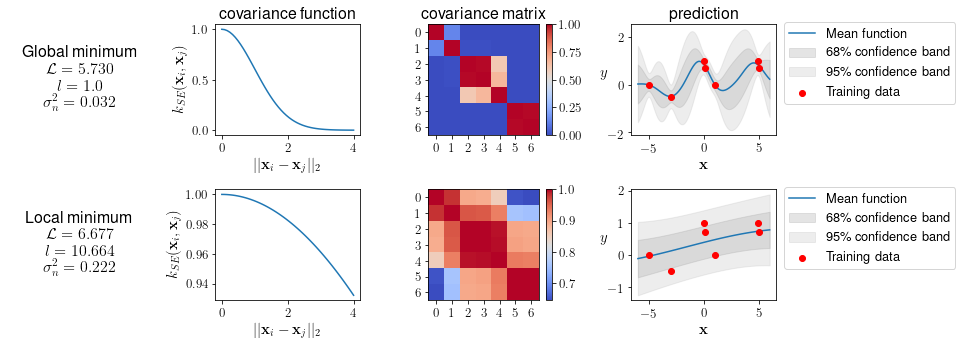

In [14]:
fig, axes = plt.subplots(2, 4, figsize=(14,5))
        
for (row, model) in zip(range(2), [gpr_model_small_length_scale, gpr_model_large_length_scale]):
    model.kernel.plot_covar_function(ax=axes[row,1])
    axes[row,1].set(xlabel=r'$||\mathbf{x}_i-\mathbf{x}_j||_2$', ylabel=f'$k_{{SE}}(\mathbf{{x}}_i,\mathbf{{x}}_j)$')

    model.plot_covariance_matrix(ax=axes[row,2])
    axes[row,2].set_xticks(np.arange(0, 7, 1))
    axes[row,2].set_yticks(np.arange(0, 7, 1))

    model.predict(plot=True, ax=axes[row,3])
    axes[row,3].legend(loc='center right', bbox_to_anchor=(1.78, 0.4, 0.5, 0.5))
    axes[row,3].set_xlabel(r'$\mathbf{x}$')
    axes[row,3].set_ylabel(r'$y$', rotation=0)
    
for (col, title) in zip(range(1,4),['covariance function', 'covariance matrix', 'prediction']):
    axes[0,col].set_title(title, fontsize='16')

axes[0,0].axis('off')
axes[0,0].text(0.5, 0.5, 'Global minimum \n $\mathcal{{L}}=5.730$ \n $l=1.0$ \n $\sigma_n^{2}=0.032$', fontsize=16, ha='center', verticalalignment='center')    

axes[1,0].axis('off')
axes[1,0].text(0.5, 0.5, 'Local minimum \n $\mathcal{{L}}=6.677$ \n $l=10.664$ \n $\sigma_n^{2}=0.222$', fontsize=16, ha='center', verticalalignment='center')    
    
plt.tight_layout()
plt.savefig('local_min.png', dpi=100, bbox_inches='tight')

<img align='left' src="img_notebook/blog_post_32_0.png"> <a name="fig-2"></a>

**Figure 2**: Illustrating the effect of local minima of the marginal likelihood on training and prediction. Both models employ the same data for training and prediction, respectively, and only differ in the hyperparameters obtained from maximum likelihood estimations with different initial values. 

The visual comparison in [Figure 2](#fig-2) shows that the resulting models differ quite significantly and thus offer different interpretations of the data:

The small length-scale of $l = 1.0$ (top panel in [Figure 2](#fig-2)) gives the (apparent) global minimum arising from the fact that our model can fit the data very well. The small noise value ($\sigma_n^{2}=0.032$) keeps the mean (posterior) function (blue line) very close to the training instances (red dots).

Using the hyperparameters from the local minimum (bottom panel [Figure 2](#fig-2)), we arrive at a model that looks smoother thanks to the larger length-scale ($l = 10.664$). This model also contains more noise ($\sigma_n^{2}=0.222$), which blows up the complexity term. Both factors, the larger length-scale and the increased noise, contribute to the relatively large distance between training outputs and the mean function. 

The previous example, which is taken from [[4]](#ref-4), is a bit constructed to show the impact of local minima. The employed data set contains only seven entries. In general, the surface of the marginal likelihood gets more pronounced with more data due to the increasing impact of the complexity penalty. So, in practice multiple local minima may not be that much of a problem [[4]](#ref-4). Still, it is a good idea to run a few (local) minimizations with different start values. Global minimization algorithms such as basin hopping would be another alternative that is often slower though.

The previous example, which is taken from [[4]](#ref-4), is a bit constructed to show the impact of local minima. The employed data set contains only seven entries. In general, the surface of the marginal likelihood gets more pronounced with more data due to the increasing impact of the complexity penalty. So, in practice multiple local minima may not be that much of a problem [[4]](#ref-4). Still, it is a good idea to run a few (local) minimizations with different start values. Global minimization algorithms such as basin hopping would be another alternative that is often slower though.

## 6. Conclusion and Outlook <a id="conclusion"></a>
---
In this article, we have learned how to identify good hyperparameters for GP regression based on a maximum likelihood estimation, and how to use them subsequently for performing predictions on unseen test data. Further, we have built some intuition on how hyperparameters are treated in Bayesian statistics, and how the BFGS algorithm performs numerical minimization of an objective function, here the negative logarithm of the marginal likelihood.

GPs are pretty versatile and extremely useful for numerous ML tasks, including clustering, time series forecasting, and reinforcement learning. There is also an interesting link between Gaussian processes and neural networks: Gaussian processes are equivalent to infinitely wide, randomly initialized, neural networks for a considerable number of architectures, including deep convolutional networks and recurrent neural networks [[6]](#ref-6).

Most state-of-the-art methods for hyperparameter optimization rely on gradient-free Bayesian optimization, aiming to balance the exploitation vs. exploration of hyperparameter space by constructing a probabilistic surrogate model for the objective function. This surrogate model is continually updated during optimization, thereby enabling smarter choices for the next iterate of hyperparameters. The most common surrogate models rely on GPs or the Tree-structured Parzen estimator. It could well be that Bayesian optimization will be covered in one of the next blog posts.

In the meantime, if you are more interested in hyperparameter optimization, I would recommend the following paper as a starting point, as it summarizes the different strategies pretty nicely [[7]](#ref-7). 

## References
---

<a name="ref-1"></a> 
1. Bergstra, J., & Bengio, Y. (2012). [Random search for hyper-parameter optimization.](http://www.jmlr.org/papers/v13/bergstra12a.html) *J. Mach. Learn. Res.*, 13(10), 281–305. 

<a name="ref-2"></a> 
2. MacKay, D. J. C. (1996). [Hyperparameters: Optimize, or integrate out?](https://link.springer.com/chapter/10.1007/978-94-015-8729-7_2) In G. R. Heidbreder (Ed.), *Maximum Entropy and Bayesian Methods: Santa Barbara, California, U.S.A., 1993* (pp. 43–59). Springer Netherlands. 

<a name="ref-3"></a> 
3. Lalchand, V., & Rasmussen, C. E. (2020). [Approximate inference for fully bayesian gaussian process regression.](http://proceedings.mlr.press/v118/lalchand20a.html
) *Symposium on Advances in Approximate Bayesian Inference*, 1–12. 

<a name="ref-4"></a> 
4. Rasmussen, C. E., Williams, C. K. I. (2006). [*Gaussian Processes for Machine Learning*](http://www.gaussianprocess.org/gpml/chapters/). The MIT Press.

<a name="ref-5"></a> 
5. Nocedal, J., & Wright, S. J. (2006). [*Numerical optimization*](https://link.springer.com/book/10.1007%2F978-0-387-40065-5#toc). Springer New York.

<a name="ref-6"></a> 
6. Yang, G. (2019). [Wide feedforward or recurrent neural networks of any architecture are gaussian processes.](https://papers.nips.cc/paper/9186-wide-feedforward-or-recurrent-neural-networks-of-any-architecture-are-gaussian-processes) In *NeurIPS* (pp. 9947-9960).

<a name="ref-7"></a> 
7. Bergstra, J. S., Bardenet, R., Bengio, Y., & Kégl, B. (2011). [Algorithms for hyper-parameter optimization.](http://papers.nips.cc/paper/4443-algorithms-for-hyper) In *NeurIPS* (pp. 2546-2554). 
